# Largest Change in Temperature

In [13]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
from scipy.signal import savgol_filter
import seaborn as sns
import os, warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
cityTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCity.csv')
ctrTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv')
globtemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalTemperatures.csv')

In [4]:
globtemp['dt'] = pd.to_datetime(globtemp['dt'])
globtemp['Year'] = globtemp['dt'].apply(lambda x : x.strftime('%Y'))
globTemp = globtemp.groupby('Year').mean().reset_index(drop=False)
globTemp = globTemp[['Year']+['LandAverageTemperature']+['LandAverageTemperatureUncertainty']]
globAvg = globTemp['LandAverageTemperature'].mean()
globTemp['LandAverageTemperature'] = globTemp['LandAverageTemperature'].apply(lambda x : x - globAvg)
globTemp['Upper'] = globTemp['LandAverageTemperature'] + globTemp['LandAverageTemperatureUncertainty']
globTemp['Lower'] = globTemp['LandAverageTemperature'] - globTemp['LandAverageTemperatureUncertainty']
# globTemp.head()

In [5]:
countryTemp = ctrTemp.dropna()
#List of continents
continents = ['North America','South America','Europe','Asia','Africa','Antarcita']
#Remove continents from country temp
countryTemp = ctrTemp[~ctrTemp['Country'].isin(continents)]
countryTemp = countryTemp[~countryTemp['Country'].str.contains('(Europe)')]
countryTemp = countryTemp.dropna()
countryTemp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
5,1744-04-01,1.530,4.680,Åland
6,1744-05-01,6.702,1.789,Åland
7,1744-06-01,11.609,1.577,Åland
8,1744-07-01,15.342,1.410,Åland


In [9]:
countryTemp['dt'] = pd.to_datetime(countryTemp['dt'])
countryTemp['Year'] = countryTemp['dt'].apply(lambda x : x.strftime('%Y'))
countryTemp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Year
0,1743-11-01,4.384,2.294,Åland,1743
5,1744-04-01,1.530,4.680,Åland,1744
6,1744-05-01,6.702,1.789,Åland,1744
7,1744-06-01,11.609,1.577,Åland,1744
8,1744-07-01,15.342,1.410,Åland,1744


In [10]:
yearTemp = countryTemp.groupby(['Country','Year']).mean().reset_index(drop=False)
yearTemp['Uncertainty'] = yearTemp['AverageTemperatureUncertainty']/yearTemp['AverageTemperature']
yearTemp.head()

,Country,Year,AverageTemperature,AverageTemperatureUncertainty,Uncertainty
0,Afghanistan,1838,18.379571,2.756000,0.149949
1,Afghanistan,1840,13.413455,2.502000,0.186529
2,Afghanistan,1841,13.997600,2.452100,0.175180
3,Afghanistan,1842,15.154667,2.381222,0.157128
4,Afghanistan,1843,13.756250,2.353083,0.171056


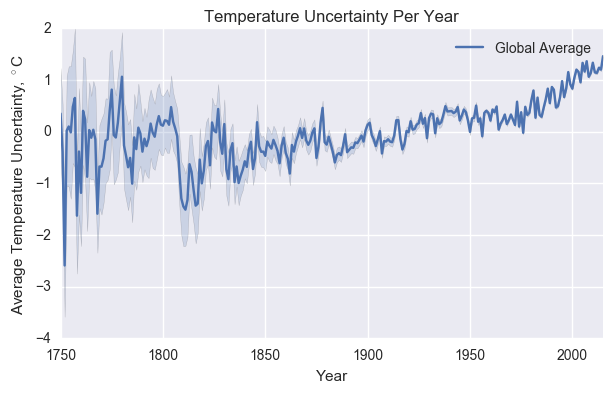

In [177]:
plt.figure(figsize=(7,4))
data = [globTemp['LandAverageTemperature'].values,globTemp['Upper'].values,globTemp['Lower'].values]
ax = sns.tsplot(time=globTemp['Year'], value="Temperature, $^\circ$C", 
                condition="Global Average",data=data) 
ax.set_ylabel('Average Temperature Uncertainty, $^\circ$C')
ax.set_title('Temperature Uncertainty Per Year')
plt.savefig("./ana_2/globalAverage.pdf", bbox_inches='tight')

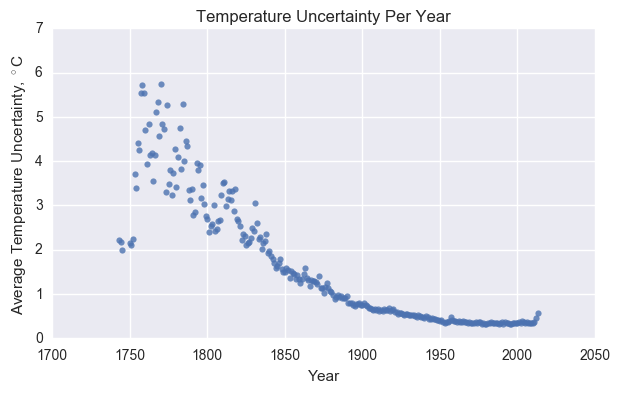

In [120]:
avgUnc = yearTemp.groupby('Year').mean().reset_index(drop=False)
data = avgUnc['Year'].apply(lambda x:int(x))
plt.figure(figsize=(7,4))
ax=sns.regplot(data,avgUnc['AverageTemperatureUncertainty'],fit_reg=False) 
ax.set_ylabel('Average Temperature Uncertainty, $^\circ$C')
ax.set_title('Temperature Uncertainty Per Year')
plt.savefig("./ana_2/uncertaintyPlot.pdf", bbox_inches='tight')

In [150]:
test = avgUnc[avgUnc['AverageTemperatureUncertainty'] <= 1.5]
test.head(10)

,Year,AverageTemperature,AverageTemperatureUncertainty,Uncertainty
106,1853,16.485486,1.363386,0.175033
108,1855,16.491861,1.465336,0.146311
109,1856,17.585535,1.459401,0.088001
110,1857,17.352906,1.337065,0.144744
111,1858,17.579217,1.438148,0.106251
112,1859,18.080226,1.329732,0.144271
113,1860,17.498630,1.249689,0.102734
114,1861,17.582417,1.341499,0.125544
115,1862,16.977373,1.455206,0.086323
117,1864,17.018095,1.352433,0.117227


In [20]:
#Seeing as the average uncertainty falls below 1.5 degrees at 1850, I feel that is
#a good year to use as a cutoff year
cutOffYear = '1860'
#Using that generalized year wasn't quite good enough so I also removed data which had
#an uncertainty greater than 1.5 degrees

In [21]:
#Top five temperature deltas since between 1850 and 2013
tempTemp = yearTemp[yearTemp['Year'] > cutOffYear]
tempTemp = tempTemp[tempTemp['AverageTemperatureUncertainty'] < 1.5]
countries = tempTemp['Country'].unique()
listHolder = []
for each in countries:
    holder = tempTemp[tempTemp['Country'] == each]
    holder.sort_values('Year')
    oldTemp = holder['AverageTemperature'].head(5).mean()
    minYear = holder['Year'].iloc[0]
    newTemp = holder['AverageTemperature'].tail(5).mean()
    diffTemp = newTemp - oldTemp
    listHolder.append((each,minYear,oldTemp,newTemp,diffTemp))
    
diffs = DataFrame(listHolder, columns=('Country',
                                       'FirstYear',
                                       'OldTemp',
                                       'NewTemp',
                                       'DiffTemp')).sort_values(by='DiffTemp', ascending=False).reset_index(drop=True)

# diffs.head()

,Country,FirstYear,OldTemp,NewTemp,DiffTemp
0,Canada,1882,-6.132433,-2.879517,3.252917
1,Azerbaijan,1861,10.396217,13.128725,2.732508
2,Ukraine,1861,7.021333,9.575300,2.553967
3,Armenia,1861,7.967367,10.436417,2.469050
4,United Arab Emirates,1861,26.951380,29.360175,2.408795


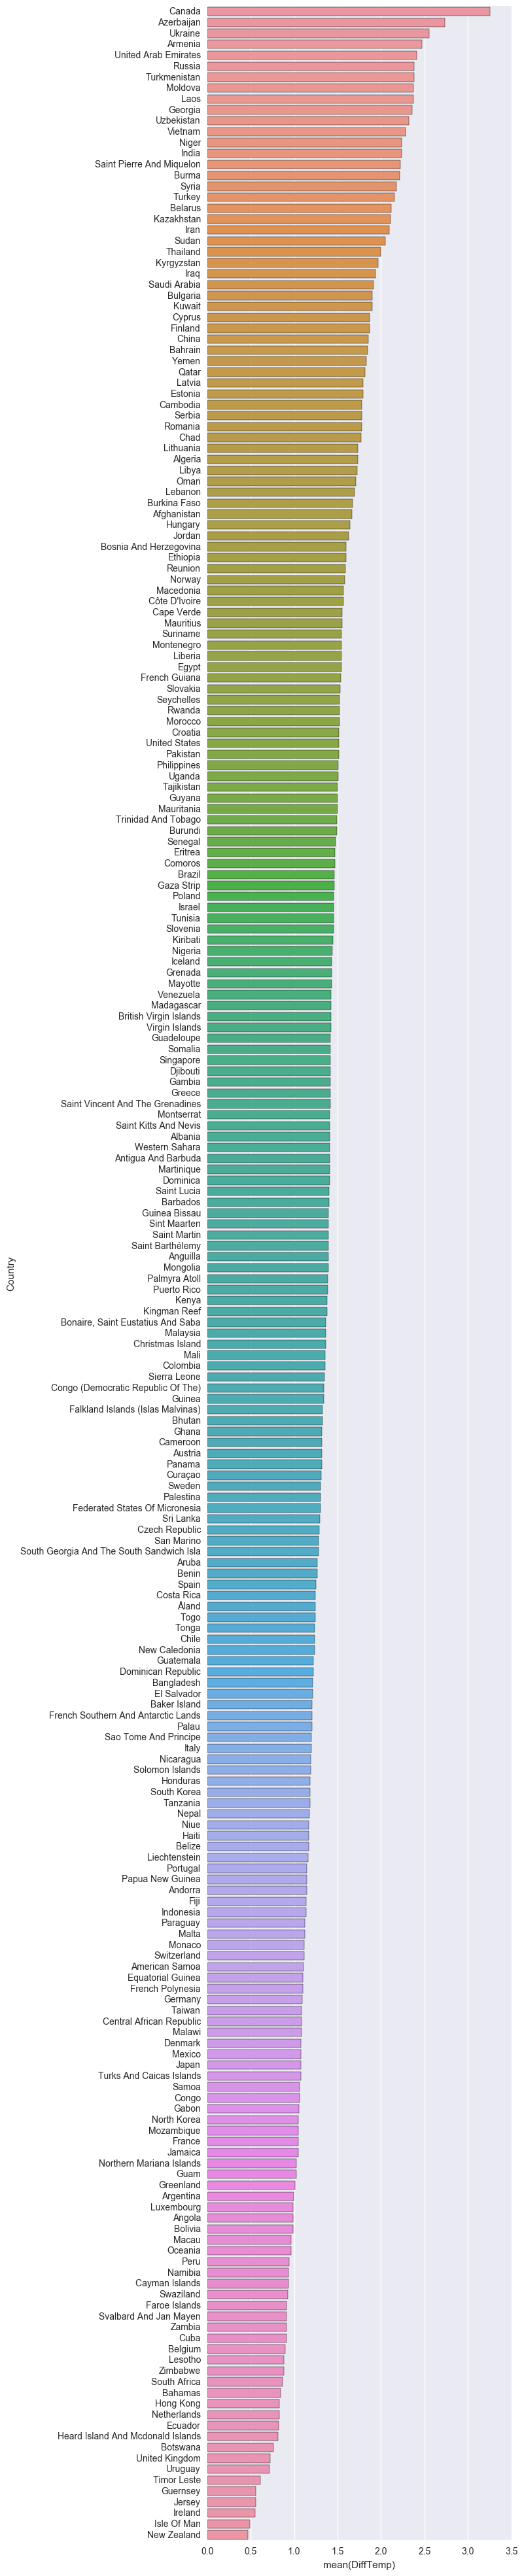

In [165]:
plt.figure(figsize=(6,50))
sns.barplot(diffs['DiffTemp'],diffs['Country'])

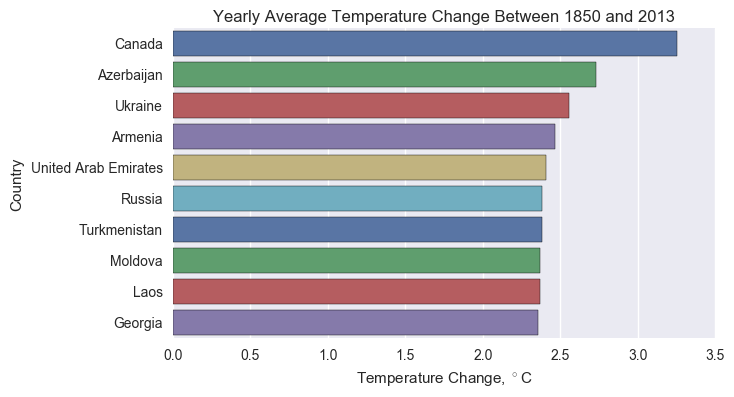

In [23]:
plt.figure(figsize=(7,4))
ax = sns.barplot(diffs['DiffTemp'][0:10],diffs['Country'][0:10],palette='deep')
ax.set_xlabel('Temperature Change, $^\circ$C')
ax.set_title('Yearly Average Temperature Change Between 1850 and 2013')
plt.savefig("./ana_2/topTenDelta.pdf", bbox_inches='tight')

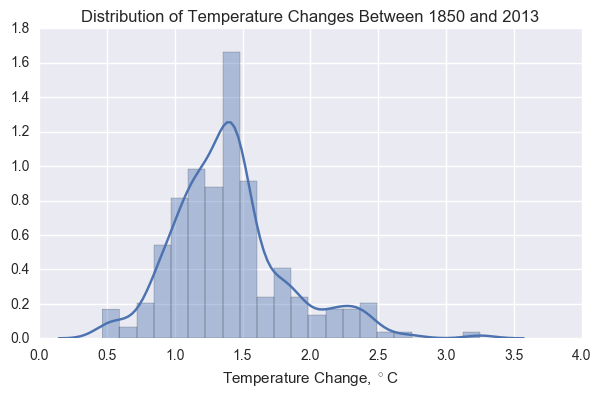

In [24]:
plt.figure(figsize=(7,4))
ax = sns.distplot(diffs['DiffTemp'])
ax.set_title('Distribution of Temperature Changes Between 1850 and 2013')
ax.set_xlabel('Temperature Change, $^\circ$C')
plt.savefig("./ana_2/deltahist.pdf", bbox_inches='tight')

In [25]:
globTemp['Country'] = 'Global'
globT = globTemp[['Country']+['Year']+['LandAverageTemperature']]
globT.columns = ['Country','Year','AvgTemp']
globT['Count'] = 0
globU = globTemp[['Country']+['Year']+['Upper']]
globU.columns = ['Country','Year','AvgTemp']
globU['Count'] = 1
globL = globTemp[['Country']+['Year']+['Lower']]
globL.columns = ['Country','Year','AvgTemp']
globL['Count'] = 2
allGlob = globT.append(globU)
allGlob = allGlob.append(globL).sort_values('Year').reset_index(drop=True)
# allGlob.head()

In [28]:
zoo = ['Canada','Greenland','Denmark','United Arab Emirates','Saudi Arabia']
data = allGlob
for each in diffs['Country'][0:5]:
    holderTemp = yearTemp[yearTemp['Country'] == each]
#     holderTemp = holderTemp[holderTemp['Year'] >= cutOffYear]
    holderAvg = holderTemp['AverageTemperature'].mean()
    holderTemp['AverageTemperature'] = holderTemp['AverageTemperature'].apply(lambda x : x - holderAvg)
    
    holderTemp['AverageTemperature'] = savgol_filter(holderTemp['AverageTemperature'], 7, 1)

    holderTemp['Upper'] = holderTemp['AverageTemperature'] + holderTemp['AverageTemperatureUncertainty']
    holderTemp['Lower'] = holderTemp['AverageTemperature'] - holderTemp['AverageTemperatureUncertainty']
        
    holderT = holderTemp[['Country']+['Year']+['AverageTemperature']]
    holderT.columns = ['Country','Year','AvgTemp']
    holderT['Count'] = 0
    holderU = holderTemp[['Country']+['Year']+['Upper']]
    holderU.columns = ['Country','Year','AvgTemp']
    holderU['Count'] = 1
    holderL = holderTemp[['Country']+['Year']+['Lower']]
    holderL.columns = ['Country','Year','AvgTemp']
    holderL['Count'] = 2

    name = each.replace(" ","")
    name = 'all'+name
    
    name = holderT.append(holderU)
    name = name.append(holderL).sort_values('Year').reset_index(drop=True)
    
    data = data.append(name)
    
# data.head()

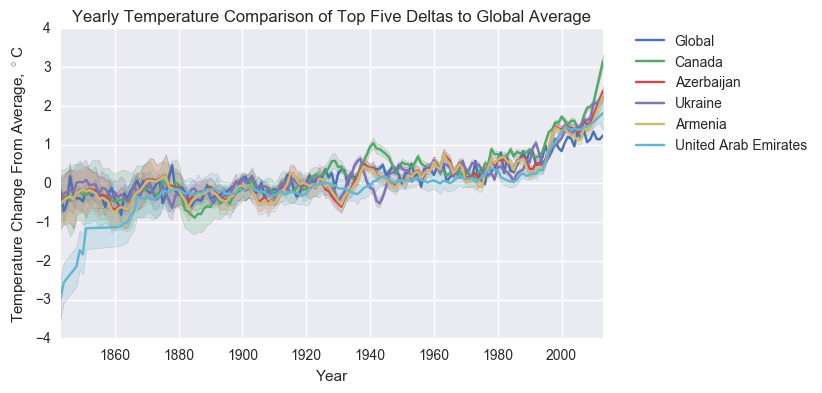

In [31]:
plt.figure(figsize=(7,4))
ax = sns.tsplot(time='Year', 
                value='AvgTemp', 
                unit='Count',
                condition='Country',
                data=data)
ax.set_title('Yearly Temperature Comparison of Top Five Deltas to Global Average')
ax.set_ylabel('Temperature Change From Average, $^\circ$C')
ax.set_ylim([-4,4])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("./ana_2/globcomparison.pdf", bbox_inches='tight')